# Wind Resource Temporal Variability Tool 

##### A python-based script to explore hourly windspeed variation at diurnal and monthly temporal scales for a given location in the continental United States.





<div>
<img src="https://www.nrel.gov/gis/assets/images/wtk-100-north-america-50-nm-01.jpg" width="750"/>
</div>

###### Map illustrating full spatial extent of the WTK data across North America. Created by Billy J. Roberts.

### Introduction 

##### In light of national goals to reach net zero emissions across all domestic economic sector activities by 2050, it is imperative to expand renewable energy development while building out the transmission infrastructure necessary to connect power generation sites with consumer demand locales. Wind power, one of the major renewable energy supplies, relies on turbines to convert wind resources into electricity through the use of rotors and generators. Given that wind power is a function of wind speed, when evaluating the predictability and consistency of wind as a renewable energy resource, it is important to understand interannual wind speed variability for power generation modeling and project financing.  

### Objective
1. Examine hourly wind speed data for 2012 at a chosen location using NREL's WIND Toolkit.
2. Develop a prototype open source tool that produces simple visualizations and statistical summaries across diurnal and monthly scales.
3. Generalize the tool so it could be scaled to run efficiently across broad geographic extents using high performance computing systems.


### Description

##### This Python script utilizes the NREL Resource eXtraction tool rex to access, extract, and analyze Wind Integration National Dataset (WIND) Toolkit (WTK) hourly (60-minute interval) data at 100m above ground level from 2012 and provides the user with the ability to create location-specific summaries and visualizations of wind speed variability across diurnal and monthly scales. Created in 2013 with funding from the Department of Energy to meet their goal of 20% domestic wind production by 2030, this WIND dataset is based on seven years of mescoscale numerical weather prediction (NWP) model output at 100m above ground level (AGL) gridded at 2km-2km resolution across the contiguous United States from 2007-2013.
***
#### Credit
##### This script was developed by Dean Berkowitz (dberkowitz@berkeley.edu) in October 2022 as requested by the National Renewable Energy Laboratory Geospatial Data Science Group. 


### Setup

In [57]:
#Import packages for analysis
import h5pyd
from rex import WindX 
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy.spatial import cKDTree
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore")
# Make all plots inline 
%matplotlib inline

#####  Gather desired windspeed data using NREL's WindX tool. 

In [2]:
from time import process_time
#Establish desired analysis data filepath. 
wtk_file ='/nrel/wtk/conus/wtk_conus_2012.h5'
#Establish target latitude, longitude for location of interest
lat = 39.7406
lon = -105.1559
#Input study area coordinates as tuple
coords = (lat, lon)
# record start time
start = process_time()
with WindX(wtk_file, hsds=True) as f: 
    df = f.get_lat_lon_df('windspeed_100m', coords)
# record end time
end = process_time()
#print processing time
print('Loaded windspeed data.', "Elapsed time using process_time()", 
      (end - start), "seconds.")
# Embed spatial information in dataframe
df['Latitude'] = lat
df['Longitude'] = lon
df

Loaded windspeed data. Elapsed time using process_time() 6.693327 seconds.


,854279,Latitude,Longitude
time_index,,,
2012-01-01 00:00:00+00:00,5.70,39.7406,-105.1559
2012-01-01 01:00:00+00:00,4.50,39.7406,-105.1559
2012-01-01 02:00:00+00:00,2.37,39.7406,-105.1559
2012-01-01 03:00:00+00:00,3.95,39.7406,-105.1559
2012-01-01 04:00:00+00:00,4.58,39.7406,-105.1559
...,...,...,...
2012-12-31 19:00:00+00:00,2.38,39.7406,-105.1559
2012-12-31 20:00:00+00:00,2.91,39.7406,-105.1559
2012-12-31 21:00:00+00:00,2.87,39.7406,-105.1559


##### Plot the target region on a continental map of the United States

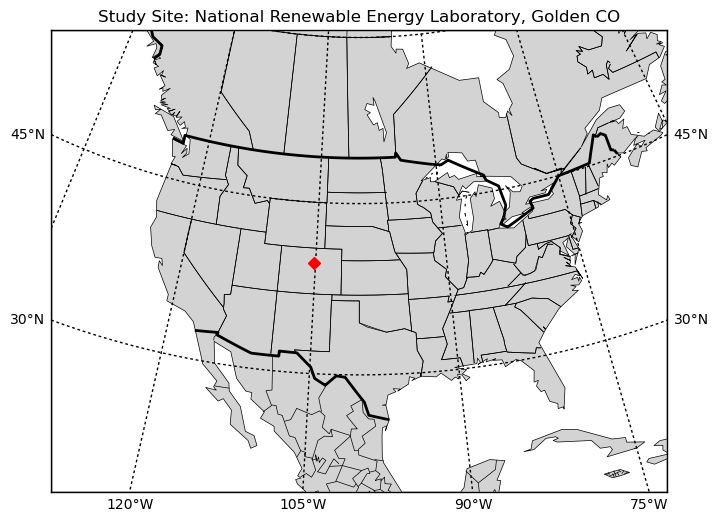

In [3]:
# Determine geographic extent 
fig = plt.figure(num=None, figsize=(10, 6)) 
m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lat_1=35.,lat_2=45,lon_0=-100,lat_0=40)
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgrey',lake_color='white')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='white')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.plot(lon, lat, marker='D',color='r', latlon=True)
#Modify title to represent location of interest
plt.title("Study Site: National Renewable Energy Laboratory, Golden CO")
plt.show()

##### Convert timezone from native (UTC) to local

In [4]:
#Convert timezone
print('Default timezone:', df.squeeze().index.tz)
# import pytz
mountain = pytz.timezone('US/Mountain')
df.index = df.index.tz_convert(mountain)

print('Converted timezone:', df.index.tz)

Default timezone: UTC
Converted timezone: US/Mountain


##### Extract temporal data from timeseries index to facilitate analyses 

In [5]:
# Copy dataset to not modify original df
wspd_df = df.copy() 
#Assign column labels 
wspd_df['Month'] = wspd_df.index.month_name()
wspd_df['Day'] = wspd_df.index.day
wspd_df['Hour'] = wspd_df.index.hour
wspd_df = wspd_df.rename(columns={df.columns[0]: 'wspd'}) # rename windspeed column to be more intuitive
#Establish seasonality
import datetime
def get_season(date: datetime.datetime, north_hemisphere: bool = True) -> str:
    now = (date.month, date.day)
    if (3, 21) <= now < (6, 21):
        season = 'Spring' if north_hemisphere else 'Autumn'
    elif (6, 21) <= now < (9, 21):
        season = 'Summer' if north_hemisphere else 'Winter'
    elif (9, 21) <= now < (12, 21):
        season = 'Autumn' if north_hemisphere else 'Spring'
    else:
        season = 'Winter' if north_hemisphere else 'Summer'
    return season

wspd_df['Season'] = wspd_df.index.map(get_season)
#rearrange column order 
wspd_df = wspd_df[['wspd', 'Month', 'Day', 'Hour', 'Season', 'Latitude', 'Longitude']]
wspd_df.sample(5, random_state=0)

,wspd,Month,Day,Hour,Season,Latitude,Longitude
time_index,,,,,,,
2012-01-23 06:00:00-07:00,4.31,January,23,6,Winter,39.7406,-105.1559
2012-09-21 11:00:00-06:00,0.98,September,21,11,Autumn,39.7406,-105.1559
2012-04-17 04:00:00-06:00,2.90,April,17,4,Spring,39.7406,-105.1559
2012-03-12 23:00:00-06:00,11.94,March,12,23,Winter,39.7406,-105.1559
2012-12-14 05:00:00-07:00,0.49,December,14,5,Autumn,39.7406,-105.1559


##### Inspect temporal record post timezone conversion. Due to original data being produced in UTC, this 2012 timeseries begins on Dec 31, 2011 at 5pm local time.

In [6]:
print(wspd_df.sort_index()[:1].index.date)

[datetime.date(2011, 12, 31)]


##### Plot annual hourly distribution to explore relative windspeed frequencies 

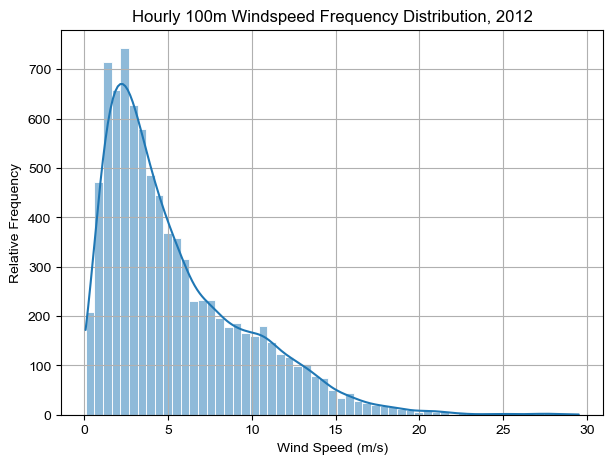

In [7]:
# Set figure size (width, height) in inches
fig, ax = plt.subplots(figsize = (7 , 5 ))
sns.set_style("whitegrid") 
# Plot the scatterplot
sns.histplot( ax = ax , x = "wspd" , data = wspd_df, kde = True) 
# Set label for x-axis
ax.set_xlabel( "Wind Speed (m/s)" , size = 10 ) 
# Set label for y-axis
ax.set_ylabel( "Relative Frequency" , size = 10 )  
# Set title for plot
ax.set_title( "Hourly 100m Windspeed Frequency Distribution, 2012" , size = 12 ) 
# Display figure
plt.grid() 
plt.show()

##### The 2012 100m windspeed distribution based on the original hourly data is positively skewed, with the bulk of the occurrences peaking at a windspeed of 3 m/s.

#### Plot annual hourly windspeed data on daily and monthly scales.

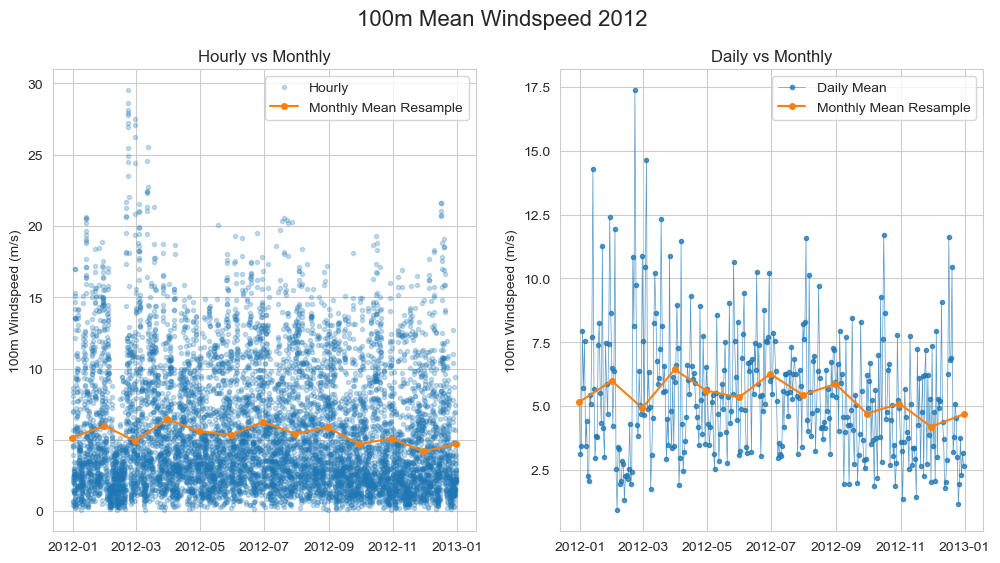

In [8]:
#Choose start, end 
start, end = '2011-12', '2012-12'
#aggregate monthly mean for resample
monthly_mean_wspd = wspd_df["wspd"].groupby(pd.Grouper(level=0, freq="M")).agg(["mean"])
monthly_mean_wspd = monthly_mean_wspd.rename(columns={'mean': 'monthly_mean_wspd'}) #update column name
#Compute daily means
daily_mean_wspd = wspd_df["wspd"].groupby(pd.Grouper(level=0, freq="D")).agg(["mean"])
daily_mean_wspd = daily_mean_wspd.rename(columns={'mean': 'daily_mean_wspd'}) #update column name
#Plot side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
sns.set_style("whitegrid")
#Dataset 1
ax1.plot(wspd_df.loc[start:end, 'wspd'],
        marker='.', alpha = 0.25, linestyle='', linewidth=0.5, label='Hourly')
ax1.plot(monthly_mean_wspd.loc[start:end, 'monthly_mean_wspd'],
marker='.', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax1.set_ylabel('100m Windspeed (m/s)')
ax1.legend();
ax1.title.set_text('Hourly vs Monthly')
#Dataset 2 
ax2.plot(daily_mean_wspd.loc[start:end, 'daily_mean_wspd'],
        marker='.', alpha = 0.75, linestyle='-', linewidth=0.5, label='Daily Mean')
ax2.plot(monthly_mean_wspd.loc[start:end, 'monthly_mean_wspd'],
marker='.', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax2.set_ylabel('100m Windspeed (m/s)')
ax2.legend();
ax2.title.set_text('Daily vs Monthly')
#Set main title
fig.suptitle('100m Mean Windspeed 2012', fontsize=16)
plt.show()

##### Visualize annual mean windspeed diurnal cycle to understand baseline variation.

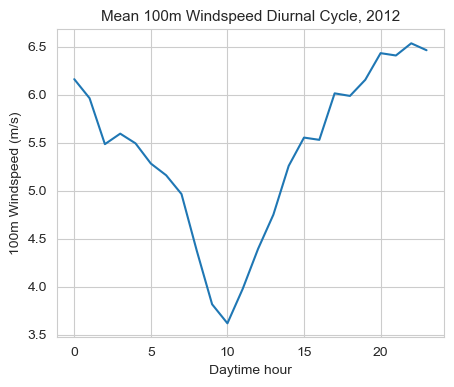

In [9]:
#Create mean diurnal cycle
diurnal = wspd_df.groupby('Hour')[['wspd']].mean()
diurnal = diurnal.rename(columns={'wspd': 'mean hourly windspeed'})
#Plot 
plt.figure(figsize = (5,4))
ax = sns.lineplot(data = diurnal,
            x = 'Hour',
            y= 'mean hourly windspeed')
ax.set_ylabel('100m Windspeed (m/s)')
ax.set_xlabel('Daytime hour')
ax.set_title("Mean 100m Windspeed Diurnal Cycle, 2012" , size = 11)
plt.show()

##### Explore seasonality of windspeed diurnal cycles.

Text(0.5, 0.98, 'Seasonal Mean 100m Windspeed Diurnal Cycle, 2012')

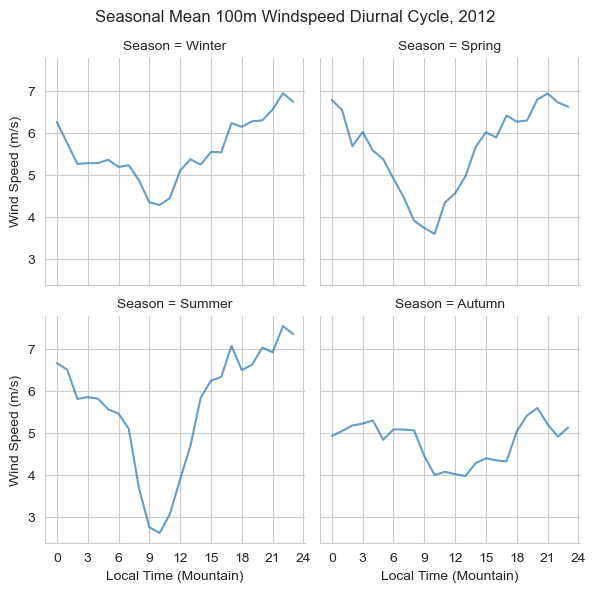

In [10]:
#Plot Seasonal Mean Diurnal Cycle of 100m windspeed
mean_seasonal = wspd_df.groupby(['Season', 'Hour']).mean().drop(columns=['Day'])
mean_seasonal = mean_seasonal.rename(columns={'wspd': 'mean seasonal wspd'}) 
#Index seasons by order
from pandas.api.types import CategoricalDtype
season_order = CategoricalDtype(
    ['Winter', 'Spring', 'Summer', 'Autumn'], 
    ordered=True)
mean_seasonal = mean_seasonal.reset_index()
mean_seasonal['Season'] = mean_seasonal['Season'].astype(season_order)
# Initialize Figure
g = sns.FacetGrid(mean_seasonal, col = 'Season', height = 3, col_wrap=2)
#Establish plotting variables 
g.map(sns.lineplot, "Hour", "mean seasonal wspd", alpha=.7)
#Set x-axis ticks
g.set(xticks=range(0, 25, 3)) 
#Set x-axis label
g.set_axis_labels("Local Time (Mountain)", "Wind Speed (m/s)")
# Adjust subplot distance
g.fig.subplots_adjust(top=0.9) 
#Set main plot title
g.fig.suptitle('Seasonal Mean 100m Windspeed Diurnal Cycle, 2012')

##### Generate monthly summary statistics on an hourly basis.

In [60]:
monthly_summary = wspd_df.drop(columns=['Latitude', 'Longitude', 'Day']).groupby(['Month', 'Hour'], as_index=False).agg(['mean', 'min', 'max'])
monthly_summary.columns = list(map(''.join, monthly_summary.columns.values))
monthly_summary

wspdmean  wspdmin  wspdmax
Month     Hour                            
April     0     6.500333     0.29    12.69
          1     5.916333     0.92    13.37
          2     4.895333     0.87    13.25
          3     5.020000     0.13    14.09
          4     4.726667     0.36    10.86
...                  ...      ...      ...
September 19    4.345667     0.60    10.61
          20    4.852000     0.41    13.71
          21    5.064667     0.22    15.10
          22    5.032667     0.80    12.28
          23    5.397333     0.24    13.29

[288 rows x 3 columns]

##### Plot monthly diurnal cycles

Text(0.5, 0.98, 'Monthly Mean 100m Windspeed Diurnal Cycle, 2012')

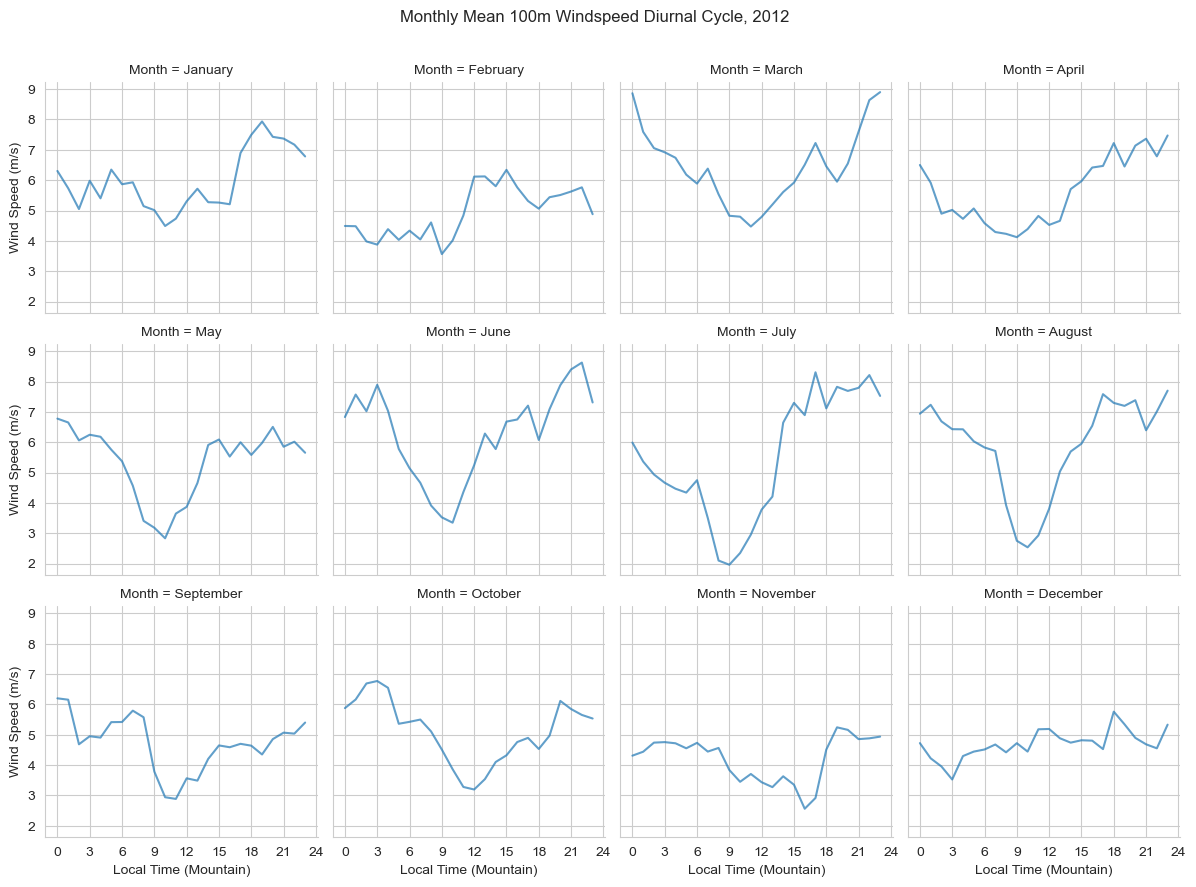

In [37]:
monthly_summary = monthly_summary.reset_index()
month_order = CategoricalDtype(
    ['January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'], 
    ordered=True)
monthly_summary['Month'] = monthly_summary['Month'].astype(month_order)
# Initialize Figure
g = sns.FacetGrid(monthly_summary.reset_index(), col = 'Month', height = 3, col_wrap=4)
#Establish plotting variables 
g.map(sns.lineplot, "Hour", "wspdmean", alpha=.7)
#Set x-axis ticks
g.set(xticks=range(0, 25, 3)) 
#Set x-axis label
g.set_axis_labels("Local Time (Mountain)", "Wind Speed (m/s)")
# Adjust subplot distance
g.fig.subplots_adjust(top=0.9) 
#Set main plot title
g.fig.suptitle('Monthly Mean 100m Windspeed Diurnal Cycle, 2012')

In [48]:
##### Generate daily summary statistics.

In [58]:
daily_summary = wspd_df.drop(columns=['Latitude', 'Longitude', 'Hour']).groupby(['Month', 'Day']).agg(['mean', 'min', 'max'])
daily_summary

wspd             
                   mean   min    max
Month     Day                       
April     1    6.630833  0.96  15.92
          2    8.969167  4.30  12.19
          3    7.295417  1.61  12.69
          4    1.910000  0.54   3.38
          5    2.985417  0.36   8.04
...                 ...   ...    ...
September 26   3.675417  0.80   9.36
          27   2.915833  0.64   5.98
          28   2.574583  0.22   5.16
          29   2.935833  0.50   6.74
          30   6.237916  0.83  14.69

[366 rows x 3 columns]

### Conclusion
1. This tool enables a preliminary assessment of windspeed temporal variability enables users to understand wind resource potential for regions of interest.
2. To understand technical potential for power generation, user would apply power curves to derive gW relative to windspeed.
3. To understand economic potential, user would utilize supply curves to derive potential energy costs ($/kW) relative to modeled windspeed capacity.
4. Ultimately, mapping pre-existing transmission infrastructure relative to study sites would indicate grid integration possibilities for wind resources, in addition to accounting for preexisting land use exclusions that obstruct development potential.